Let us setup an interactive `Python` session where we can run the code
developed here.

``` jupyter
print("Welcome to EMACS Jupyter")
```

We develop topological analyses of brain circuits, and implement
`Python` code that we can use with to configure a `connsense-pipeline`.
Instead of the connectivity of the whole circuit *Mosaic*, our focus
will be `circuit-subtargets` that are geometrically defined. We will
start by describing how to configure a `connsense-pipeline`, run it, and
use `connsensnse-tap` to access and analyze the data.

# Setup

In our discussion we will develop scientific concepts to measure the
circuit, and implement Python functions to compute them. Here we setup a
notebook template to test and explore, and the structure of a `Python`
package for our methods.

## Introduction

In [ ]:
from importlib import reload
from collections.abc import Mapping
from collections import OrderedDict
from pprint import pprint, pformat
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib

reload(matplotlib)
from matplotlib import pylab as plt
import seaborn as sbn

from IPython.display import display

from bluepy import Synapse, Cell, Circuit

GOLDEN = (1. + np.sqrt(5.))/2.
print("We will plot golden aspect ratios: ", GOLDEN)


## Workspaces

We have run `connsense-CRAP` for the SSCx dissemination variant *Bio-M*,
extracting data that we will use to compute the factology. Here is a
list of workspaces we will need to generate factsheets.

In [ ]:
ROOTSPACE = Path("/")
PROJSPACE = ROOTSPACE / "gpfs/bbp.cscs.ch/project/proj83"
SOODSPACE = PROJSPACE / "home/sood"
CONNSPACE = SOODSPACE / "topological-analysis-subvolumes/test/v2"
DEVSPACE  = CONNSPACE / "test" / "develop"


## `connsense` Modules

While test-developing it will be good to have direct access to the
`connsense-TAP-store` we will use. We will use a module from `connsense`
to load the HDFstore,

In [ ]:
from connsense.develop import topotap as cnstap
tap = cnstap.HDFStore(CONNSPACE/"pipeline.yaml")
circuit = tap.get_circuit("Bio_M")
print("Available analyses: ")
pprint(tap.analyses)


## Notebook template

Finally, here is a template that we can use to start test-developing. We
will deposit the code in a sub-directory, of the directory holding this
file.

In [ ]:
<<notebook-init>>

<<notebook-workspaces>>

<<notebook-connsense-tap>>

<<notebook-reloads>>


# Introduction

We will study flatmap columns. In the circuit's flatmap we have the
following grid,

In [ ]:
from flatmap_utility import subtargets as fmst, tessellate
flat_xys = fmst.fmap_positions(in_data=circuit)
tritille = tessellate.TriTille(230.0)
graphic_fmap_cells = tritille.plot_hextiles(flat_xys,
                                            annotate=False, with_grid=False, pointmarker=".", pointmarkersize=0.05)
graphic_fmap_cells[0]


# Pipeline: TODO

# TAP CLI

# Subtargets

We have information about subtargets in `tap`,

In [ ]:
display(tap.subtargets)


Each one is a straight up cylinderical column in the flatmap-space, and
a conical column in circuit's physical space. Each `subtarget` is
associated with a list of gids,

In [ ]:
fig_subtarget_sizes = plt.figure(figsize=(GOLDEN * 8, 8))

ax = sbn.histplot(tap.subtarget_gids.apply(len).values, bins=25,
                  ax=fig_subtarget_sizes.add_subplot())


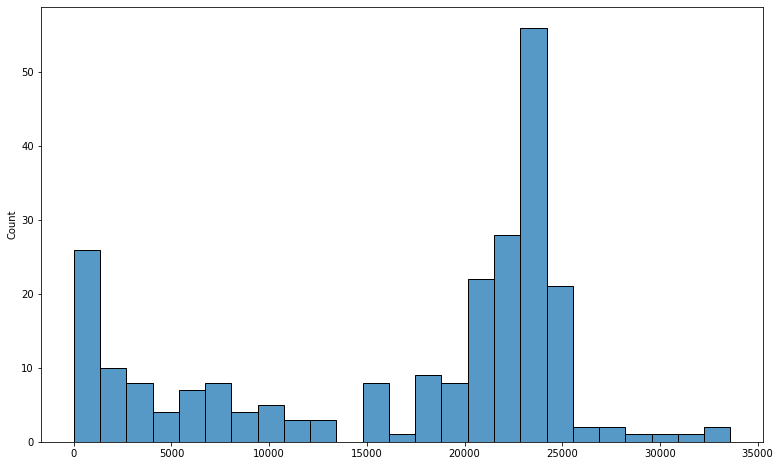

# Nodes

We extract node properties as `extract-node-populations/default`, and
can access the node-properties using `tap`,

In [ ]:
nodes = cnstap.TapDataset(tap, ("extract-node-populations", "default"), belazy=False)


We can get a frame for all the nodes over all the subtargets by calling
`.frame`,

In [ ]:
nodes.frame.describe()


As you can tell from the numbers that the `nodes` dataframe contains all
the nodes in all the subtargets (*i.e* all circuit nodes except those
that could not be flatmapped). This dataframe is no different from the
`circuit.cells` one, except that the `subtarget` is avaialble in the
index,

In [ ]:
display(nodes.frame[ ["gid", "layer", "mtype"] ].head())


Notice the `node_id` which is not the same as `gid`. The `node_id` value
is local to the `subtarget`.

# Adjacency matrices

Adjacency matrices for edges in the local connectome were extracted as
`extract-edge-populations/local`. This data is stored as sparse
matrices, and hence using `.frame` on the non-lazy data not make much
sense. The data is also much larger than nodes. We should stick to the
lazy `datacalls` loaded by `tap`,

In [ ]:
display(tap.adjacency.frame.head())


Each entry can be expanded when needed,

In [ ]:
adj = tap.adjacency.dataset.iloc[0]()

print("matrix of type", type(adj), "and shape", adj.shape,
      "number of connections", adj.astype(bool).sum())


# Analyses

## Simplex counts

We already have results for simplex-counts in a `tap-store` resulting
from a run of the \~connsense-pipeline- developed in <span
class="spurious-link" target="Pipeline">*Pipeline*</span>. Let us load
the simplex-counts,

In [ ]:
simplex_counts = cnstap.TapDataset(tap, ("analyze-connectivity", "simplex-counts"),
                                   belazy=False)
print("Simplex counts as a %s"%(type(simplex_counts),))


We have run simplex counts for both the full (original and 5 ER
controls) adjacency matrices, and their slices by layer. We can load the
results for the `full-flatcolumns` as a dataframe,

In [ ]:
simplex_counts.frame["full"]


This computation will take a while, as all the simplex counts, for both
the full and layer will be decompressed from `connsense.h5` and loaded
into a `pandas.DataFrame`. In about a minute you should see the result.
Once loaded, the dataframe will stay with the object
`simplex_counts.frame`. For layers we have an extra level in the index,

In [ ]:
simplex_counts.frame["layer"]


We find a `nan` where no simplices were found. Each individual
computation on a single `flatcolumn` returns an array / series of
simplex counts by dimension *upto* the maximum dimension of simplices
found in that `flatcolumn`. When we concatenated these data into a
single `frame`, the max-dimension was set to the maximum of maxima over
all `flatcolumns` (and their randomizations). This filled in `nan`
values for `flatcolumns` that did not have the higher missing
dimensions. While we can replace the `nans` by zeros, as that is what
they mean, they do offer a convenient way to compute the max-dimension,

In [ ]:
from tqdm import tqdm; tqdm.pandas()

maxdim = (simplex_counts.frame["full"]
          .apply(lambda subtarget: len(subtarget.dropna()), axis=1)
          .rename("dim"))

display(maxdim)


which we can convert to a plot,

In [ ]:
fig_maxdim = plt.figure(figsize=(GOLDEN * 8, 8))
_ax = sbn.violinplot(x="control", y="dim", data=maxdim.reset_index(),
                     ax=fig_maxdim.add_subplot())
fig_maxdim


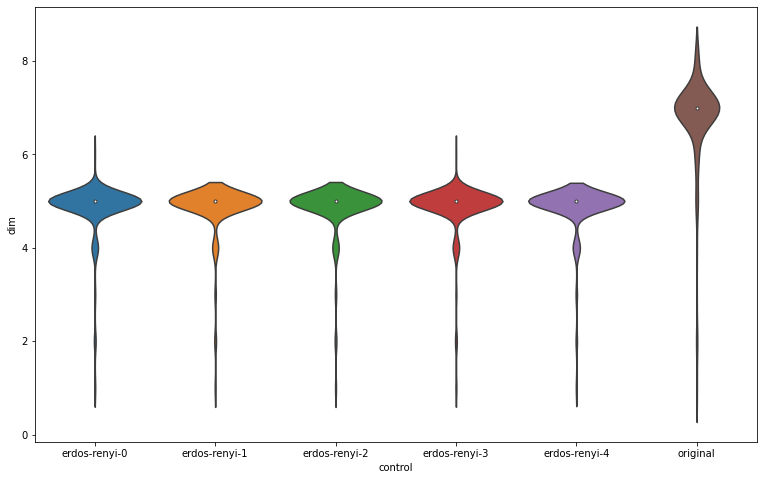

What about each layer?

In [ ]:
maxdim_by_layer = (simplex_counts.frame["layer"]
                   .apply(lambda subtarget: len(subtarget.dropna()), axis=1)
                   .rename("dim"))

display(maxdim_by_layer)


and it looks like,

In [ ]:
fig_maxdim_by_layer = plt.figure(figsize=(GOLDEN * 8, 8))
_ax = sbn.violinplot(x="control", y="dim", hue="layer", data=maxdim_by_layer.reset_index(),
                     ax=fig_maxdim_by_layer.add_subplot())
fig_maxdim_by_layer


## Model Params DD2

Loading the results for second order distance dependent model is similar
to simplex counts,

In [ ]:
params_dd2 = cnstap.TapDataset(tap, ("analyze-connectivity", "model-params-dd2"),
                               belazy=False)
display(params_dd2.frame)


# Scratch